In [1]:
%load_ext autoreload
%autoreload 2

In [15]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mesh_import import mesh
import mesh.affix as affix
from mesh.affix import CkipAffixoids
from mesh.affix import AffixoidCtmDataset, AffixoidCtmProcessor
from mesh.affix import ctm_analysis

In [ ]:
ctm = ctm_analysis.get_ctm_models()

In [ ]:
import numpy as np
from collections import defaultdict

In [ ]:
beta = ctm.model.model.beta.detach().cpu().numpy()

In [ ]:
ctm.model.best_components.shape

In [ ]:
beta.shape

In [ ]:
k=10
topics = defaultdict(list)
for i in range(100):
    idxs = np.argsort(beta[i])[-k:]
    component_words = [ctm.vocab.decode(int(idx))
                       for idx in idxs]
    topics[i] = component_words

In [ ]:
topics[2]

In [ ]:
beta = ctm.get_beta()

In [ ]:
beta.shape

In [12]:
import torch.nn.functional as F
import torch
topic_distr = F.softmax(beta, dim=0)

In [13]:
topic_entropy = (-torch.log(topic_distr) * topic_distr).sum(0)
topic_entropy = topic_entropy.detach().cpu().numpy()

c:\python38\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
c:\python38\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([3.091e+03, 1.536e+03, 2.537e+03, 7.790e+03, 2.398e+03, 2.460e+02,
        6.600e+01, 3.200e+01, 7.000e+00, 8.570e+02]),
 array([2.4568794e-33, 3.0382282e-01, 6.0764563e-01, 9.1146839e-01,
        1.2152913e+00, 1.5191140e+00, 1.8229368e+00, 2.1267595e+00,
        2.4305825e+00, 2.7344053e+00, 3.0382280e+00], dtype=float32),
 <a list of 10 Patch objects>)

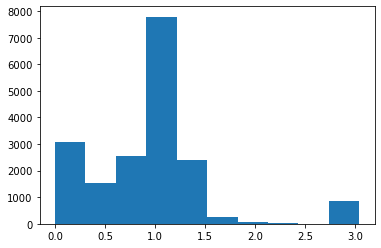

In [16]:
plt.hist(topic_entropy)

## Affixoids

In [17]:
affix_dir = mesh.get_data_dir() / "affix"
affixoids = CkipAffixoids(affix_dir)

In [18]:
ctm.get_affixoid_entropy(affixoids[0])

0.0051618167